In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [32]:
df = pd.read_excel(r"C:\Users\mm0692\Desktop\project develoment phase\Dataset\DataSet1986-2018.xlsx")
df.head()
df[:10]

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
5,1986-01-09,26.03
6,1986-01-10,25.65
7,1986-01-13,25.08
8,1986-01-14,24.97
9,1986-01-15,25.18


In [34]:
df.columns

Index(['Date', 'Closing Value'], dtype='object')

In [3]:
#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Closing Value'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [4]:
df.head()

,Closing Value
Date,
2000-01-04,25.56
2000-01-05,24.65
2000-01-06,24.79
2000-01-07,24.79
2000-01-10,24.71


Data Preprocessing

In [5]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [6]:
DfInfo(df)

,Closing Value
column type,float64
null values (nb),0
null values (%),0.0


In [7]:
df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-18',
               ...
               '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29',
               '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
               '2018-07-06', '2018-07-09'],
              dtype='datetime64[ns]', name='Date', length=4673, freq=None)

In [8]:
y = df['Closing Value'].resample('MS').mean()

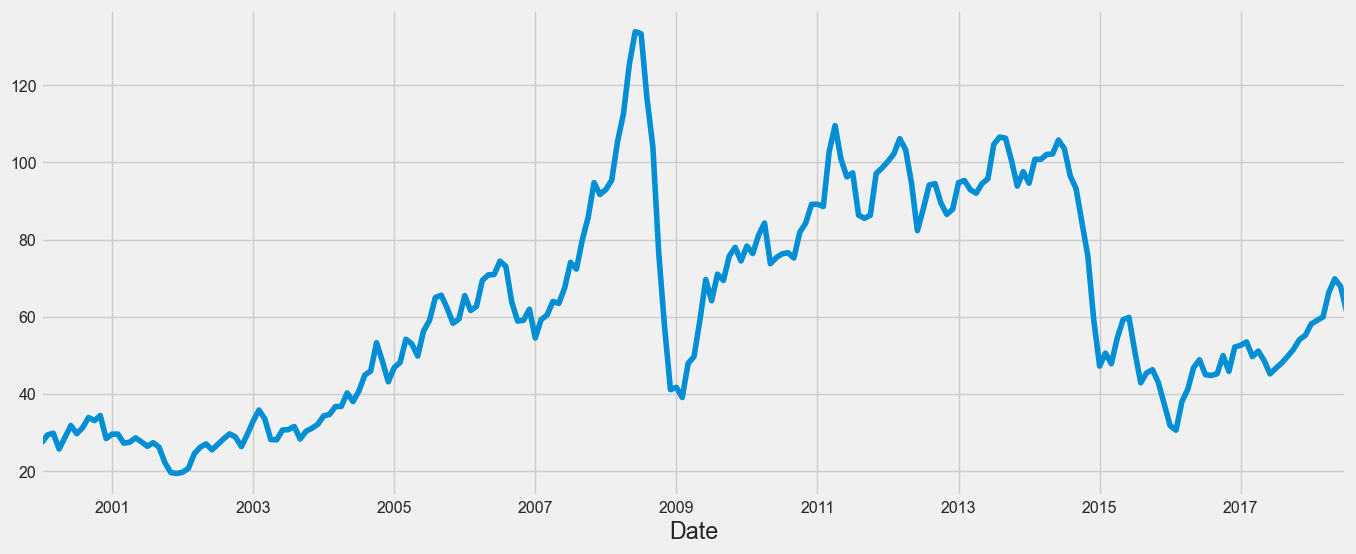

In [9]:
y.plot(figsize=(15, 6))
plt.show()

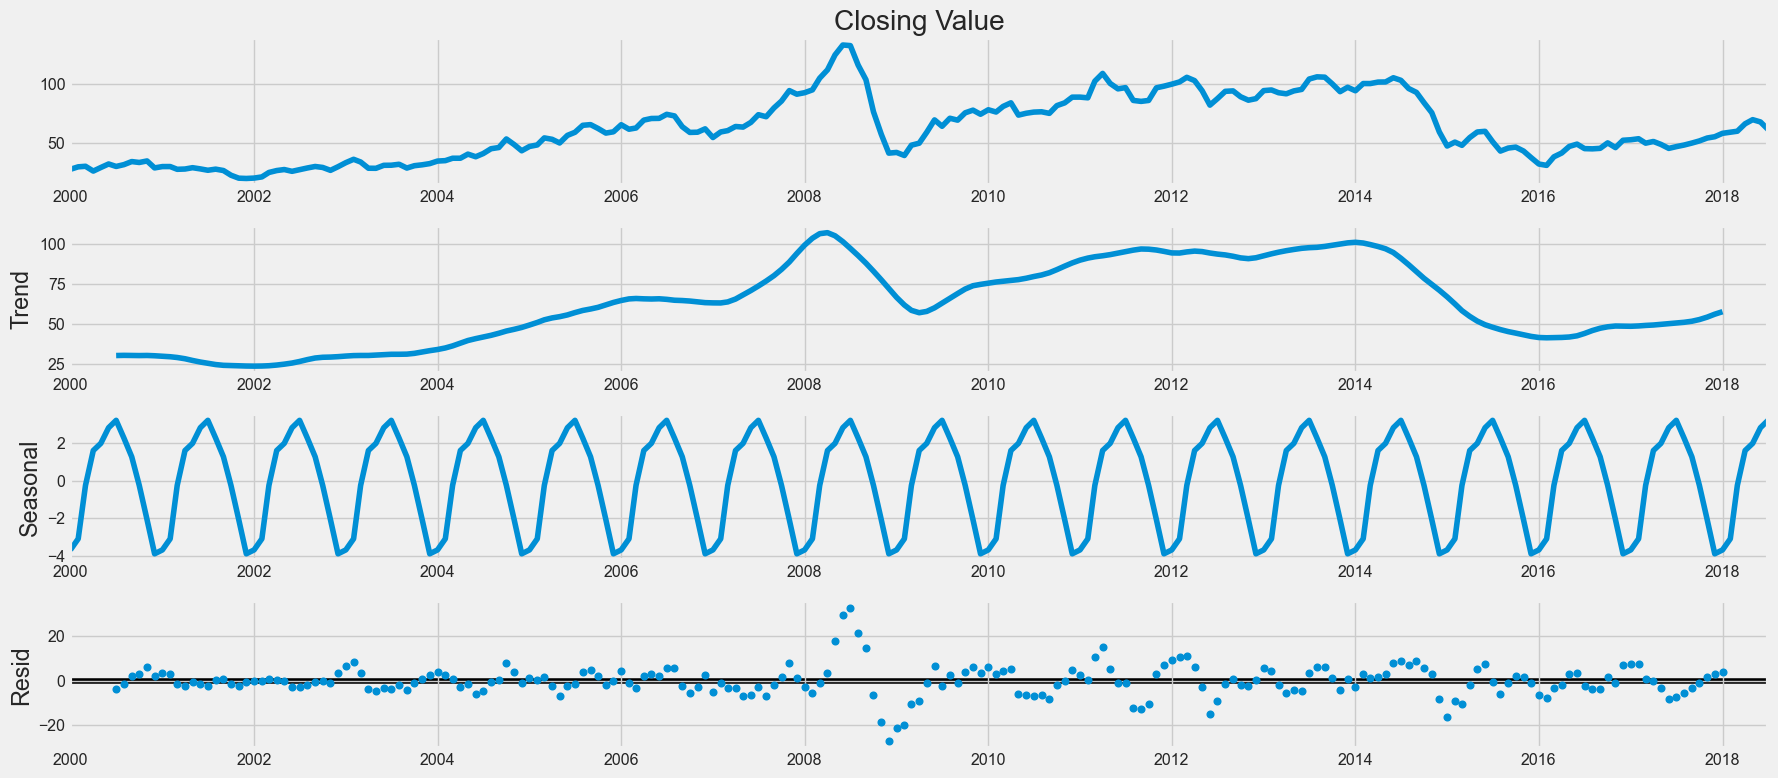

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

## Training and Testing the Dataset

In [12]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [13]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [14]:
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Adding LSTM Layer

In [15]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
212/212 [==============================] - 28s 95ms/step - loss: 0.0049 - val_loss: 0.0231 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 18s 82ms/step - loss: 0.0115 - val_loss: 0.0502 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 18s 87ms/step - loss: 0.0128 - val_loss: 0.0506 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 20s 92ms/step - loss: 0.0167 - val_loss: 0.0471 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 17s 81ms/step - loss: 0.0204 - val_loss: 0.0582 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 17s 80ms/step - loss: 0.0203 - val_loss: 0.0587 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 19s 89ms/step - loss: 0.0245 - val_loss: 0.0037 - lr: 1.0000e-04
Epoch 8/20
212/212 [==============================] - 17s 79ms/step - loss: 0.0035 - val_loss: 0.0027 - lr: 1.0000e-04
Epoch 9/20
212/212 [==============================] - 17s 82ms/step - lo

Training the model

In [16]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

41/41 [==============================] - 1s 31ms/step


In [17]:
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 2.6373620808199516
Train Root Mean Squared Error: 3.5844323680159773
Test Mean Absolute Error: 2.4599980004701245
Test Root Mean Squared Error: 5.342938854397161


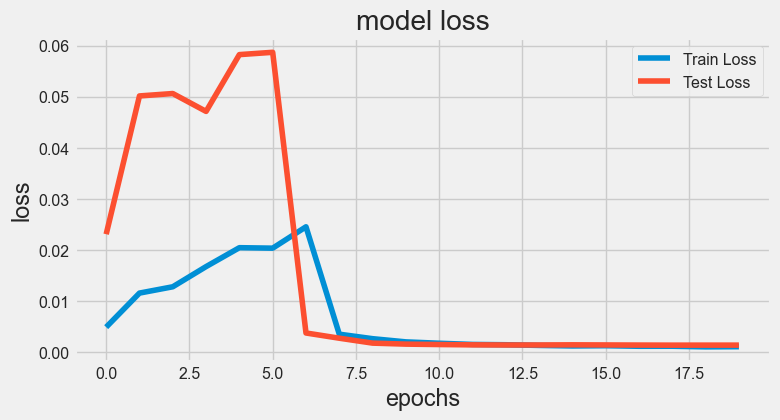

In [18]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

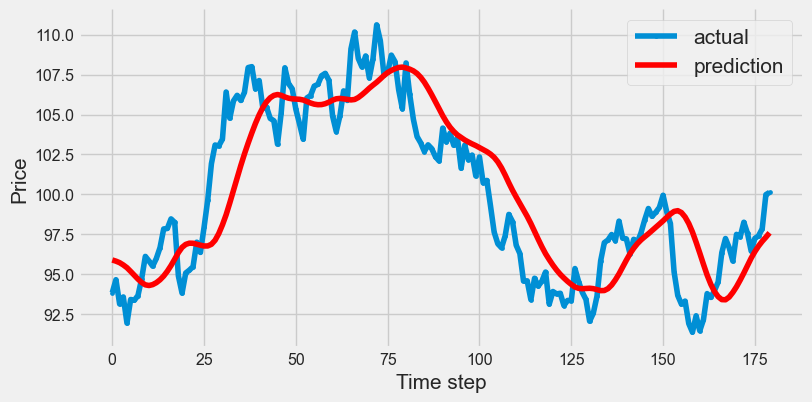

In [19]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [35]:
data_oil = df.reset_index()['Closing Value']

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

In [39]:
train_predict=scaler.inverse_transform(train)
test_predict=scaler-inverse_transform(test)
import math
from sklearn.metrics import mean_squared_error
math. sqrt(mean_squared_error(train,train_predict))

29.347830443269938